### IMPORTS

In [1]:
from Inference.VariationalAE import MeanFieldVariationalAE

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [5]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

# Load data #

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [8]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

# Model principal

In [9]:
model = nn.Sequential( nn.Linear(1,20),
                       nn.Tanh(),               
                       nn.Linear(20,1),
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [10]:
param_count = get_param(model).shape[0]
param_count

61

In [11]:
flip_parameters_to_tensors(model)

# Modèle génératif: Hypernet autoencodeur

In [12]:
#choisir la dimension pour les paramètres latents
# lat_dim=5 donne des résultats intéressants!
lat_dim=5

In [13]:
# initialise 
# – (encodeur) une gaussienne diagonale N(0,sigma*I): mfvar ("dummy" prior sur les variables latentes)
# – (decodeur) un NN avec 1 layer param_count neurones, activtion nn.Tanh()/nn.ReLU(): decoder
# forward(n): échantilloner theta=mfvar.decoder(mfvar.sample(n))
sigma_p=1.
VAE = MeanFieldVariationalAE(lat_dim,10,param_count,nn.Tanh(),sigma=sigma_p)
print('nb de paramètres VAE:'+str(get_param(VAE).shape[0]))
VAE


nb de paramètres VAE:741


MeanFieldVariationalAE(
  (mfvar): MeanFieldVariationalDistribution()
  (layerIn): Linear(in_features=5, out_features=10, bias=True)
  (layerOut): Linear(in_features=10, out_features=61, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=61, bias=True)
  )
)

In [17]:
#prior sur les paramètres lambda du decodeur

#poids d'entrée avant activation
def prior_hyperWeightsIn(w):
    return torch.nn.init.normal_(w,mean=0., std=4.)

#poids de sortie
def prior_hyperWeightsOut(w):
    return torch.nn.init.normal_(w,mean=0., std=0.2)



In [18]:
#initialise les paramètres lambda du decoder, couche par couche
def init_weightsIn(m):
    if type(m) == nn.Linear:
        prior_hyperWeightsIn(m.weight)
        m.bias.data.fill_(0.01)
def init_weightsOut(m):
    if type(m) == nn.Linear:
        prior_hyperWeightsOut(m.weight)
        m.bias.data.fill_(0.01)
        
VAE.layerIn.apply(init_weightsIn)
VAE.layerOut.apply(init_weightsOut)

Linear(in_features=10, out_features=61, bias=True)

# Initialisation #

le prior sur les paramètres $\theta$ du modèle principal est déterminé par le prior N(0,I) sur les variables latentes et par le l'initialisation du decodeur. C'est l'état du VAE avant entraînement. 

<IPython.core.display.Javascript object>


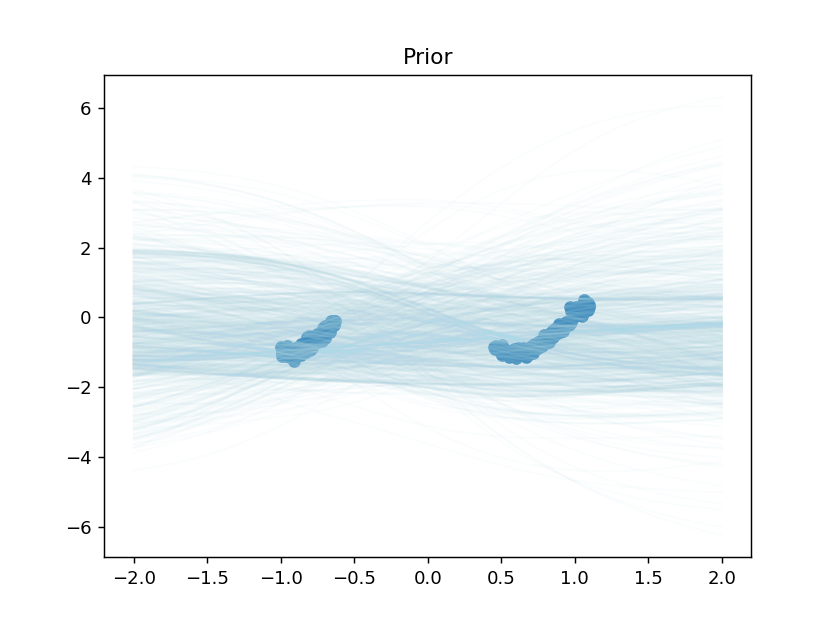

In [19]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
import math

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.title('Prior')


plt.scatter(x_data.cpu(), y_data.cpu())
#plt.plot(x_test.detach().cpu().numpy(),torch.cos((4*x_test)+0.8).cpu().numpy(),color='red')
for i in range(1000):
    z = VAE.mfvar.sample()
    theta=VAE.decoder(z)
#    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)
    
#    plt.axis('scaled')
#    plt.xlim(-0.2, 0.7) 
#    plt.ylim(-4,4) 
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')


# likelihood sur les paramètres latents #

In [20]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [21]:
# température :-)
sigma_like=.1 

# le likelihood d'un paramètre latent z étant donnée data est obtenu:
# 1. en décodant z: theta=decoder(z)
# 2. en utilisant theta comme paramètres du modèle principal
# 3. point estimate, pour chaque donnée (x,y) avec normal N(y_pred,sigma_like)
# En d'autres mots, pour tout decoder_lambda avec paramètres lambda:  
#z is likely for a single data (x,y) iff 
# y_pred=M_{decoder_lambda(z)}(x) is close to y (with respect to scale sigma_like)

def loglikelihood(z, sigma=sigma_like):
    theta=VAE.decoder(z)
    set_all_parameters(model, theta)
    y_pred = model(x_data)
    L = _log_norm(y_pred, y_data, torch.tensor([sigma],device=device))
    return torch.sum(L).unsqueeze(-1)

# KL-divergence #

$$D_\text{KL}\left(\mathcal{N}\left((\mu_1, \ldots, \mu_k)^\mathsf{T}, \operatorname{diag} (\sigma_1^2, \ldots, \sigma_k^2)\right) \parallel \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)\right) = {1 \over 2} \sum_{i=1}^k (\sigma_i^2 + \mu_i^2 - \ln(\sigma_i^2) - 1).$$

$$D_\text{KL}\left(\mathcal{N}\left((\mu_1, \ldots, \mu_k)^\mathsf{T}, \operatorname{diag} (\sigma_1^2, \ldots, \sigma_k^2)\right) \parallel \mathcal{N}\left(\mathbf{0}, \sigma^2\mathbf{I}\right)\right) = {1 \over 2} \sum_{i=1}^k \Big(\frac{\sigma_i^2}{\sigma^2} + \frac{\mu_i^2}{\sigma^2} +\ln(\sigma^2)- \ln(\sigma_i^2) - 1\Big).$$

In [22]:
# KL-divergence entre une normale diagonale N(mu,diag(sigma)) et N(0,I)
def KLDivGauss(mu,sigma):
    Div=sigma+torch.pow(mu,2)-sigma.log()-1
    return 0.5*Div.sum().squeeze()

In [23]:
# KL-divergence entre une normale diagonale N(mu,diag(sigma)) et N(0,I)
def KLDivGauss_(mu,sigma,sigma_p):
    Div_=torch.mul(sigma,1/sigma_p)+torch.mul(torch.pow(mu,2),1/sigma_p)-sigma.log()-1+torch.log(torch.Tensor([sigma_p]))
    return 0.5*Div_.sum().squeeze()

In [24]:
KLDivGauss_(VAE.mfvar.mu.detach(),VAE.mfvar.sigma.detach(),sigma_p)

tensor(0.)

# Training #

Il n'est pas possible de caluler la fonction de densité de notre distribution apprise sur les paramètres $\theta$ du modèle principal. Nous pouvons seulement échantilloner cette distribution via fonction forward de VAE, on échantillonne z selon VAE.mfvar.sample() puis on applique le decoder theta=VAE.decoder(z).

L'idée est donc de modéliser le posterior sur les VARIABLES LATENTES z (et non sur theta) selon la loi de Bayes:
$$
P(z|\text{data})=\frac{P(\text{data}|z)P(z)}{P(\text{data})}
$$
où le prior $P(z)$ est $N(0,I)$. Le logarithme du likelihood $P(\text{data}|z)$ est définit par la fontion log_likelihood(z,sigma) et dépend des paramètres $\lambda$ du decodeur. Notons $P(\text{data}|z)=P_\lambda(\text{data}|z)$ pour rendre explicite cette dépendance sur $\lambda$. On a 
$$\log P_\lambda(\text{data}|z)=\sum_{(x,y)} \log P(y |\text{Model}_{\text{decoder}_\lambda(z)}(x),\sigma_\text{like})$$
où $p(y |\text{Model}_{\text{decoder}_\lambda(z)}(x),\sigma_\text{like})$ est normale de moyenne $\text{Model}_{\text{decoder}_\lambda(z)}(x)$ est scale $\sigma_\text{like}$. À noter que l'évidence $P_\lambda(\text{data})=\int P_\lambda(\text{data}|z)P(z) dz$ dépend également des paramètres $\lambda$ du decoder.

La divergence entre une distribution $Q(z)$ est le postérieur est donnée pour tout $\lambda$ par:
$$
D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z|\text{data}) )=D_\text{KL}(Q(z)\mathbin{\Vert} P(z)) - E_{Q(z)}[\log P_\lambda(\text{data}|z)]+ \log(P_\lambda(\text{data})).
$$
Ainsi:
$$
\log P_\lambda(\text{data})= E_{Q(z)}[\log P_\lambda(\text{data}|z)]- D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z) )-D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z|\text{data})) \geq E_{Q(z)}[P_\lambda(\text{data}|z)]- D_\text{KL}(Q(z) \mathbin{\Vert} P(z) )
$$
puisque $D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z|\text{data}))\geq 0$ pour toute distirbution $Q$ et tout $\lambda$.

On minimise donc la fonction:
$$
-\text{ELBO}(\mu,\sigma,\lambda) = D_\text{KL}(Q(z) \mathbin{\Vert} P(z) )- E_{Q(z)}[\log P_\lambda(\text{data}|z)]
$$
où $Q(z)$ est normale diagonale $N(\mu, diag(\sigma))$ (c'est VAE.mfvar) et $log P_\lambda(\text{data}|z)$ dépend des paramètres $\lambda$ du decoder (VAE.decoder). Pour tout $\mu,\sigma, \lambda$ on a
$$
\log P_\lambda(\text{data})\geq \log P_\lambda(\text{data})-D_\text{KL}(Q_{\mu,\sigma}(z) \mathbin{\Vert} P_\lambda(z|\text{data}) )=\text{ELBO}(\mu,\sigma,\lambda)
$$

Si $D_\text{KL}(Q(z) \mathbin{\Vert} P(z))$ peut être calculée en dollars et ne dépend pas de $\lambda$, le terme $E_{Q(z)}[\log P_\lambda(\text{data}|z)]$ est estimé en échantillonant des $z_i$ (et donc des $\theta_i=\text{decoder}_\lambda(z_i)$) puis en faisant la moyenne des $\log P_\lambda(\text{data}|z_i)$.



In [25]:


n_samples_VAR = 400

In [29]:
VAE_optimizer = torch.optim.Adam(VAE.parameters(), lr=.01)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=60, factor=0.5)


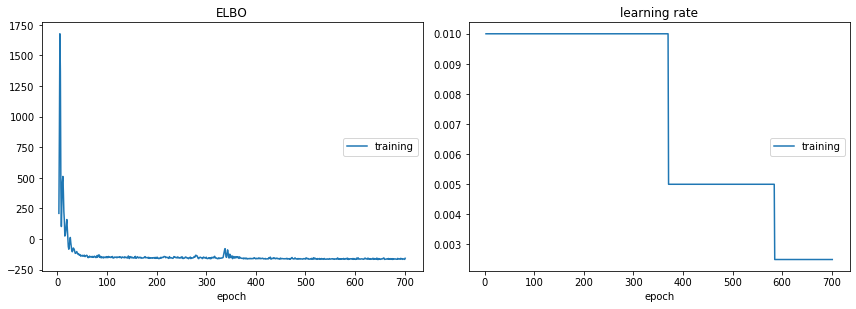

ELBO:
training   (min: -167.475, max: 3244.546, cur: -157.391)

learning rate:
training   (min:    0.003, max:    0.010, cur:    0.003)


KeyboardInterrupt: 

In [37]:
%matplotlib inline

liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    learning_rate = VAE_optimizer.param_groups[0]['lr']
    
    #Div = KLDivGauss_(VAE.mfvar.mu,VAE.mfvar.sigma,sigma_p)
    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
    LL=torch.Tensor(n_samples_VAR)

    for i in range(n_samples_VAR):
        z = VAE.mfvar.sample()
        LL[i]=loglikelihood(z)

    L = Div - LL.mean()

    L.backward()
    

    

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    #if t %2 == 0:
    VAE_optimizer.step()

    if learning_rate < 0.00001:
        break

# Résultats #

In [38]:
(VAE.mfvar.mu,VAE.mfvar.sigma)

(Parameter containing:
 tensor([-0.1711, -0.0132,  0.0181, -0.1379, -0.0099], requires_grad=True),
 tensor([1.7302, 0.2675, 0.3348, 3.0721, 0.2826], grad_fn=<LogBackward>))

In [39]:
for layer in VAE.decoder.modules():
    if isinstance(layer, nn.Linear):
        print(layer.weight)
        print(layer.bias)

Parameter containing:
tensor([[ 4.2323, -5.1139, -0.7129,  1.2090,  4.1821],
        [ 1.3381,  0.1373,  0.4291, 12.8269,  2.4043],
        [ 5.3304,  2.5403, -0.4368,  2.9576,  1.3387],
        [-2.3422,  1.0655,  1.2429,  3.2781, -6.6851],
        [ 4.9498,  2.2770, -1.1831, -2.4475, -0.3794],
        [ 8.0831,  4.1131,  2.9555,  6.9710,  0.4205],
        [ 4.7747, -2.7760, -0.5134, -4.5766, -4.5675],
        [ 1.0988,  2.0281, -0.5949, 11.2601,  2.7039],
        [ 2.0566,  1.0059,  0.0556,  4.4505,  1.0181],
        [-3.7255,  1.6285, -3.8869,  7.3503,  2.5957]], requires_grad=True)
Parameter containing:
tensor([-0.1335, -0.1625, -0.0957,  0.0739, -0.0394, -0.0832, -0.1963, -0.0897,
        -0.0629, -0.0310], requires_grad=True)
Parameter containing:
tensor([[ 2.8950e-02,  3.9360e-02, -3.4710e-02,  6.9045e-03,  1.0868e-01,
          2.7866e-02, -2.7544e-02, -7.8142e-03,  2.2540e-02, -3.1808e-02],
        [ 1.1125e-01,  1.4853e-01, -1.7170e-01,  4.4843e-02,  3.8384e-01,
          1.3

<IPython.core.display.Javascript object>


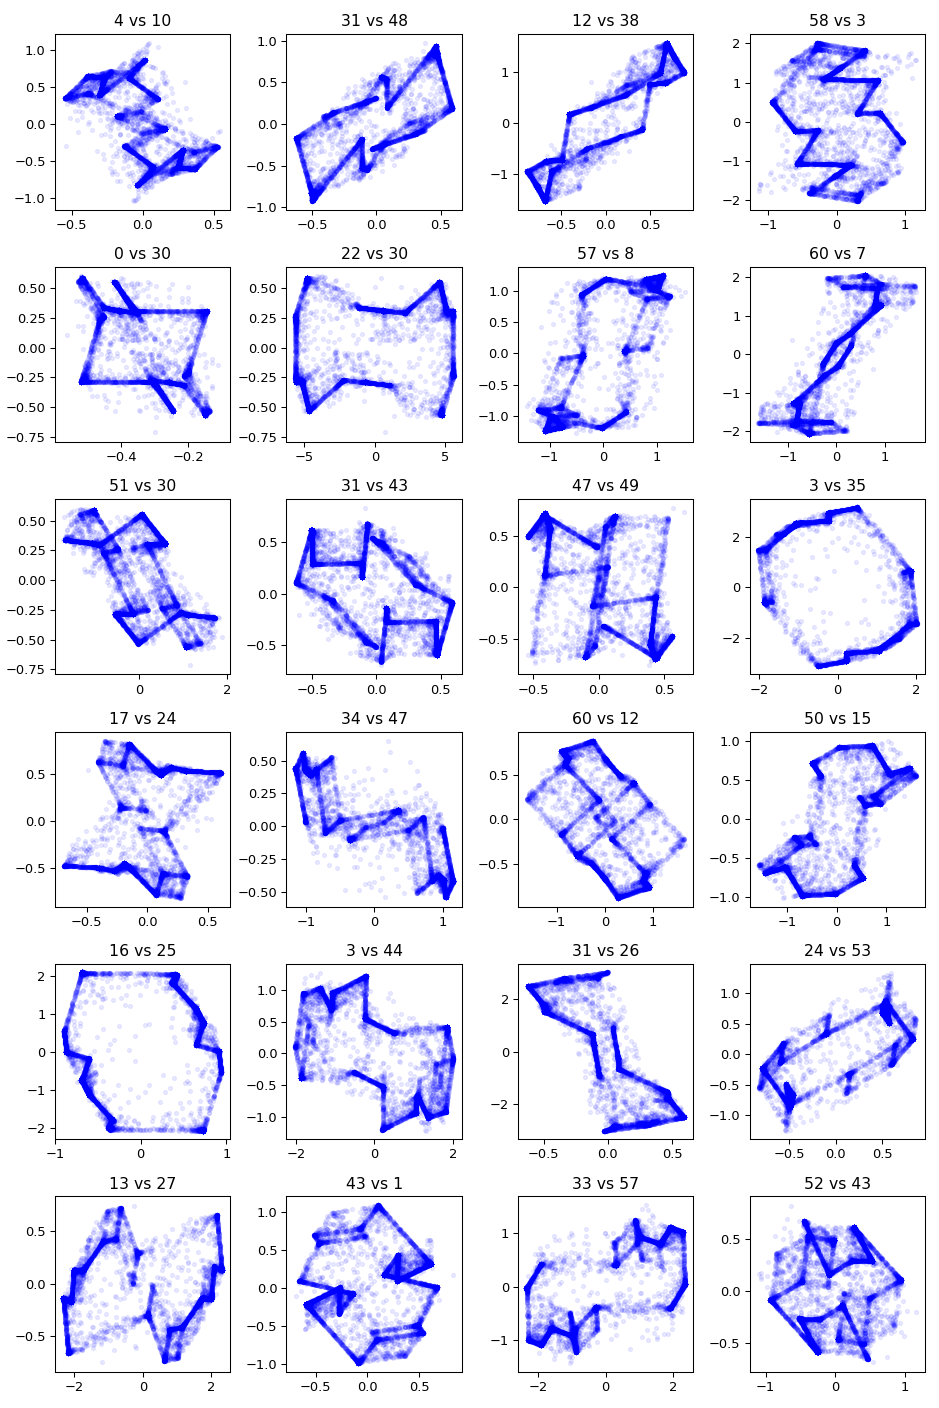

In [40]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters

import matplotlib.pyplot as plt
%matplotlib notebook

L = VAE(10000).detach().numpy()


fig, axs = plt.subplots(6, 4,figsize=(10,15))
for k in range(6):
    for l in range(4):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.08,color='blue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution ##


<IPython.core.display.Javascript object>


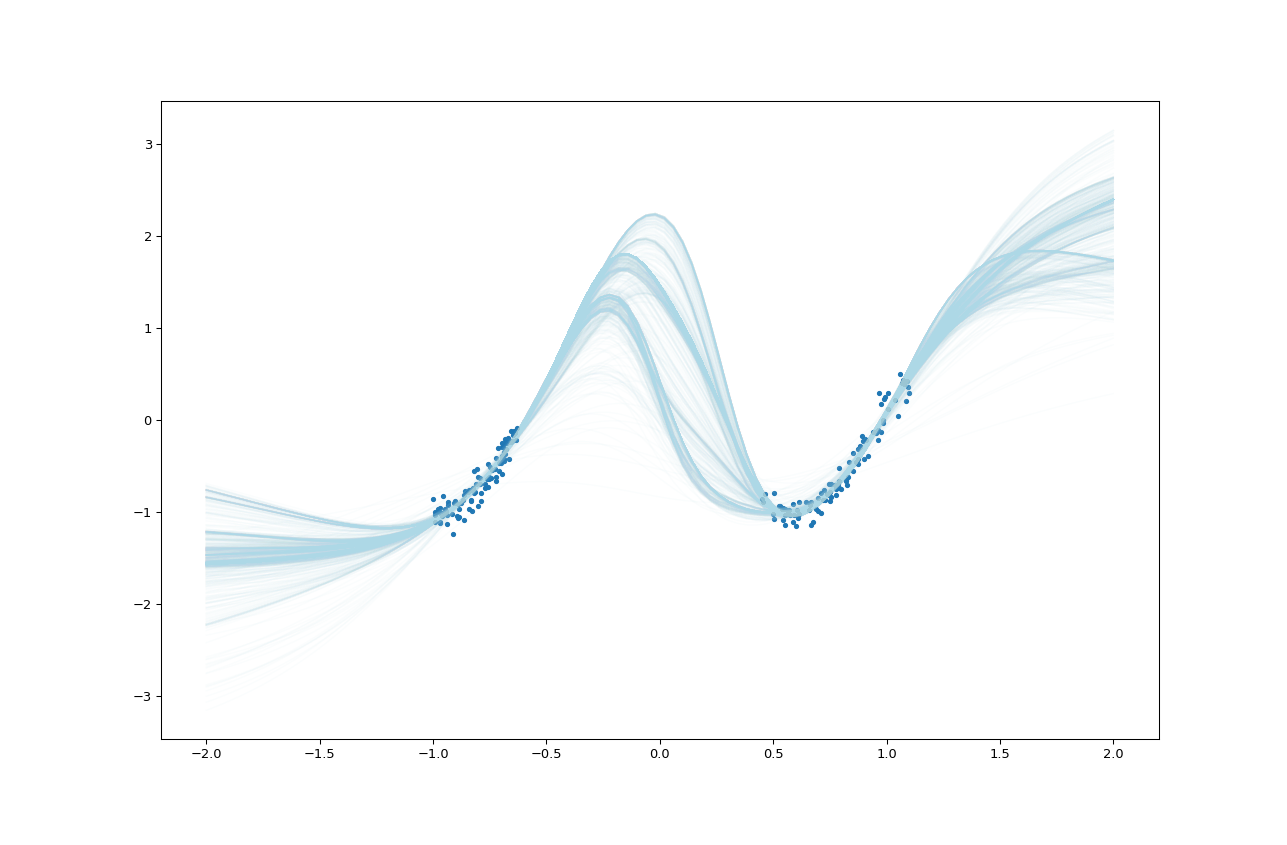

In [42]:
import matplotlib.pyplot as plt
%matplotlib notebook

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
for i in range(1000):
    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



# Calcul de l'évidence #

In [44]:
n_samples=10000

prior=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(lat_dim), torch.eye(lat_dim))
E=torch.Tensor(n_samples)

for i in range(n_samples):
    z = prior.sample().unsqueeze(0)
    E[i]=loglikelihood(z)

evidence=E.logsumexp(0)-torch.log(torch.Tensor([n_samples]))

print('Log-évidence: '+str(evidence.squeeze().detach().numpy()))

Log-évidence: 171.25714


In [45]:
# estimation de l'évidence en utilisant la distribution apprise VAE.mfvar
E=torch.Tensor(n_samples)

for i in range(n_samples):
    z = VAE.mfvar.sample() 
    E[i]=loglikelihood(z)


print('Log-évidence estimée: '+str((E.logsumexp(0)-torch.log(torch.Tensor([n_samples]))).squeeze().detach().numpy())) 

Log-évidence estimée: 173.10349


In [46]:
Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
LL=torch.Tensor(n_samples)

for i in range(n_samples):
    z = VAE.mfvar.sample()
    LL[i]=loglikelihood(z)

L = Div - LL.mean()


In [47]:
L+evidence

tensor([8.5572], grad_fn=<AddBackward0>)